|  | model | tp | fn | tn | fp | precision | recall | f0.5 | f1 | f2 | processing time per frame
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| whole image | stage-1-unfreeze |0.745 | 0.255 | 0.993 | 0.007 | 0.757 | 0.745 | 0.751 | 0.747 | 0.745 | 0.604 / **0.492**| 
| crop (resize) | try8  | 0.505 | 0.495 | 0.963 | 0.037 | 0.691 | 0.505 | 0.621 | 0.560 | 0.523 | 0.240 / **0.167** |
| crop (padded) | w_lr_4 | 0.702 | 0.298 | 0.994 | 0.006 | 0.756 | 0.702 | 0.737 | 0.721 | 0.709 | 0.33 |
| crop (padded) (gray) | w1 | 0.792 | 0.208 | 0.969 | 0.031 | 0.790 | 0.802 | 0.792 | 0.795 | 0.7996 | 0.33 |

***tp rate should be avg value. calculate tp rate for each img and take avg***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import time
import torchvision
import zipfile
from PIL import Image as im
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *
import glob
import cv2
import numpy as np

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


## **Run below cell for model 1,3,4**

In [ ]:
path_images='/content/drive/MyDrive/Stair dataset1/original_data/train'
path_valid='/content/drive/MyDrive/Stair dataset1/original_data/val'
fnames=get_image_files(path_images)

class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/Stair dataset1/original_data/train_pngs',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'train') else (posixpath.join('/content/drive/MyDrive/Stair dataset1/original_data/val_pngs',f'{x.stem}{x.suffix}'))

# mask = open_mask(get_y_fn(img_f))
# src_size = np.array(mask.shape[1:])
colors = np.loadtxt('/content/drive/MyDrive/Stair dataset1/stair.txt',delimiter='\n',dtype=str);

"""Run this for training as during training size is 1/2 nd testing size is same as original (480,640)"""
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Stair dataset1/original_data'))
   .split_by_folder(train='train',valid='val')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=(240,320))#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
  #  .add_test_folder(test_folder='test',tfms=None,tfm_y=False)#since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )

## **Run below cell for model 2**

In [ ]:
path_images='/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest/cropped_train'
path_valid='/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest/cropped_val'
fnames=get_image_files(path_images)

class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest/cropped_train_pngs',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'cropped_train') else (posixpath.join('/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest/cropped_val_pngs',f'{x.stem}{x.suffix}'))

colors = np.loadtxt('/content/drive/MyDrive/Stair dataset1/stair.txt',delimiter='\n',dtype=str);

src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest'))
   .split_by_folder(train='cropped_train',valid='cropped_val')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=(120,260))#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
  #  .add_test_folder(test_folder='test',tfms=None,tfm_y=False)#since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


## **Data and Model**

In [ ]:
# tfms = get_transforms(do_flip=True,size=src_size//2)
data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data,models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
def apply_resnet(arr,save=True):
    test_image = Image(pil2tensor(arr, dtype=np.float32).div_(255))
    img_segment = learn.predict(test_image)[0]
    test_image_data=test_image.data.permute(1,2,0)
    img_segment_data=img_segment.data*255
    img_segment_data=img_segment_data.permute(1,2,0)
    mask=img_segment.data.permute(1,2,0).numpy()
    mask=(np.squeeze(mask,axis=2))*255
    # plt.imshow(mask)
    # plt.show()
    return mask

In [ ]:
model = torch.hub.load('ultralytics/yolov5',  'custom', path='/content/drive/MyDrive/Stair dataset1/yolo_weights/best3.pt', force_reload=True)  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-17 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def apply_yolov5(bbox_array, img):
  res = model(img)
  try: 
    l = res.xyxy[0]  
    xmin = int(l[0,0])
    ymin = int(l[0,1])
    xmax = int(l[0,2])
    ymax = int(l[0,3])
    return cv2.rectangle(bbox_array,(xmin,ymin),(xmax,ymax),(255,0,0),2), xmin, xmax, ymin, ymax
  except: 
    return bbox_array, 0, 320, 0, 240

## **Approach 1 : whole image RGB**
**model:** stage-1-unfreeze \\
**train set:** original_data/train \\
**val set:** original_data/val

In [ ]:
learn.load('/content/drive/MyDrive/Stair dataset1/original_data/models/earlier training/stage-1-unfreeze')

In [ ]:
images = 0
f1_average = 0
f2_average = 0
f0_5_average = 0
precision_average = 0
recall_average = 0
tp_rate = 0
fp_rate = 0
tn_rate = 0
fn_rate = 0
flag=True
start=time.time()
# for img_number in range(760,1585):
for img_number in range(785,1585):
  try: 
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    others = 0
    img = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test2/{img_number}.png")
    img = cv2.resize(img, (320,240), interpolation=cv2.INTER_NEAREST)
    temp_mask = apply_resnet(img)

    bbox_array = np.zeros([240,320,4], dtype=np.uint8)
    bbox_array, xmin, xmax, ymin, ymax = apply_yolov5(bbox_array, img)
    xmin = max(xmin-10,0)
    xmax = min(xmax+10,320)
    ymin = max(ymin-10,0)
    ymax = min(ymax+10,240)
    predicted_mask=np.zeros((240,320), dtype=np.uint8)
    predicted_mask[ymin:ymax, xmin:xmax] = temp_mask[ymin:ymax, xmin:xmax]

    temp1 = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test_pngs/{img_number}.png")
    temp2 = temp1[:,:,0]
    true_mask = cv2.resize(temp2, (320, 240), interpolation=cv2.INTER_NEAREST)

    for i in range(predicted_mask.shape[0]):
      for j in range(predicted_mask.shape[1]):
        if predicted_mask[i][j] == 255 and true_mask[i][j] == 255:
          tp += 1
        elif predicted_mask[i][j] == 0 and true_mask[i][j] == 0:
          tn += 1
        elif predicted_mask[i][j] == 255 and true_mask[i][j] == 0:
          fp += 1
        elif predicted_mask[i][j] == 0 and true_mask[i][j] == 255: 
          fn += 1
        else: 
          others += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f0_5_score = (1.25*precision*recall)/(0.25*precision+recall)
    f1_score = (2*precision*recall)/(precision+recall)
    f2_score = (5*precision*recall)/(4*precision+recall)
    precision_average += precision
    recall_average += recall
    f0_5_average += f0_5_score
    f1_average += f1_score
    f2_average += f2_score
    tp_rate += tp/(tp+fn)
    fn_rate += fn/(tp+fn)
    tn_rate += tn/(tn+fp)
    fp_rate += fp/(tn+fp)
    images += 1

    if flag:
      end=time.time()
      print("time elapsed is {0}".format(end-start))
      flag=False

  except: 
    pass

f1_average /= images
f2_average /= images
f0_5_average /= images
precision_average /= images
recall_average /= images
tp_rate /= images
fn_rate /= images
tn_rate /= images
fp_rate /= images

time elapsed is 0.6353580951690674


In [ ]:
print(f"f0.5 average = {f0_5_average}")
print(f"f1 average = {f1_average}")
print(f"f2 average = {f2_average}")
print(f"precision average = {precision_average}")
print(f"recall average = {recall_average}")
print(f"tp rate = {tp_rate}")
print(f"fn rate = {fn_rate}")
print(f"tn rate = {tn_rate}")
print(f"fp rate = {fp_rate}")

f0.5 average = 0.751273974461059
f1 average = 0.7469657929862322
f2 average = 0.7453708642061618
precision average = 0.7571029879769712
recall average = 0.7453198517737887
tp rate = 0.7453198517737887
fn rate = 0.2546801482262111
tn rate = 0.9928513627364145
fp rate = 0.007148637263584908


## **Approach 2 : cropped + resized image RGB** 
**model:** try8_unfreeze [cropped_120y260x_interNearest/models]

**train set:** cropped_120y260x_interNearest/cropped_train \\
**val set:** cropped_120y260x_interNearest/cropped_val

In [ ]:
learn.load('/content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest/models/try8')

Learner(data=ImageDataBunch;

Train: LabelList (52 items)
x: SegItemListCustom
Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260)
y: SegLabelListCustom
ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260)
Path: /content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest;

Valid: LabelList (12 items)
x: SegItemListCustom
Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260),Image (3, 120, 260)
y: SegLabelListCustom
ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260),ImageSegment (1, 120, 260)
Path: /content/drive/MyDrive/Stair dataset1/cropped_120y260x_interNearest;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, mome

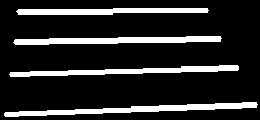

time elapsed is 5.170541763305664


In [ ]:
images = 0
f1_average = 0
f2_average = 0
f0_5_average = 0
precision_average = 0
recall_average = 0
tp_rate = 0
fp_rate = 0
tn_rate = 0
fn_rate = 0
flag=True
start=time.time()
for img_number in range(725,726):
  try: 
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    others = 0
    img= cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/train2/{img_number}.png")

    # img = cv2.resize(img, (320, 240), interpolation=cv2.INTER_NEAREST)
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    bbox_array, xmin, xmax, ymin, ymax = apply_yolov5(bbox_array, img)
    xmin = max(xmin-10,0)
    xmax = min(xmax+10,640)
    ymin = max(ymin-10,0)
    ymax = min(ymax+10,480)
    # print(xmin, xmax, ymin, ymax)
    # m_orig = img.shape[0]
    # n_orig = img.shape[1]
    img = img[ymin:ymax, xmin:xmax, :]

    img = cv2.resize(img, (260,120), interpolation=cv2.INTER_AREA)
    # m = img.shape[0]
    # n = img.shape[1]
    # img = cv2.copyMakeBorder(img, (m_orig-m)//2, (m_orig-m+1)//2, (n_orig-n)//2, (n_orig-n+1)//2, cv2.BORDER_CONSTANT, (0,0,0))
    mask = apply_resnet(img)
    # mask = mask[(m_orig-m)//2:(m_orig-m)//2+ymax-ymin, (n_orig-n)//2:(n_orig-n)//2+xmax-xmin]
    # plt.figure()
    # plt.imshow(img)
    # plt.show()


    temp1 = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/train2_pngs/{img_number}.png")
    
    true_mask = temp1[:,:,0]
    # true_mask = cv2.resize(true_mask, (320, 240), interpolation=cv2.INTER_NEAREST)

    true_mask = true_mask[ymin:ymax, xmin:xmax]
    true_mask = cv2.resize(true_mask, (260,120), interpolation=cv2.INTER_NEAREST)
    cv2_imshow(true_mask)
    # img_concate_Hori=np.concatenate((mask,true_mask),axis=1)
    # cv2_imshow(img_concate_Hori)

    # plt.figure()
    # plt.imshow(true_mask)
    # plt.show()

    for i in range(mask.shape[0]):
      for j in range(mask.shape[1]):
        if mask[i][j] == 255 and true_mask[i][j] == 255:
          tp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 0:
          tn += 1
        elif mask[i][j] == 255 and true_mask[i][j] == 0:
          fp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 255: 
          fn += 1
        else: 
          # print(predicted_mask[i][j], true_mask[i][j])
          others += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    f2_score = (5*precision*recall)/(4*precision+recall)
    f0_5_score = (1.25*precision*recall)/(0.25*precision+recall)

    precision_average += precision
    recall_average += recall
    f1_average += f1_score
    f2_average += f2_score
    f0_5_average += f0_5_score
    tp_rate += tp/(tp+fn)
    fn_rate += fn/(tp+fn)
    tn_rate += tn/(tn+fp)
    fp_rate += fp/(tn+fp)
    images += 1

    if flag:
      end=time.time()
      print("time elapsed is {0}".format(end-start))
      flag=False

  except: 
    print("error in {0}".format(img_number))

f1_average /= images
f2_average /= images
f0_5_average /= images
precision_average /= images
recall_average /= images
tp_rate /= images
fn_rate /= images
tn_rate /= images
fp_rate /= images

In [ ]:
print(f"f0.5 average = {f0_5_average}")
print(f"f1 average = {f1_average}")
print(f"f2 average = {f2_average}")
print(f"precision average = {precision_average}")
print(f"recall average = {recall_average}")
print(f"tp rate avg = {tp_rate}")
print(f"fn rate avg= {fn_rate}")
print(f"tn rate avg= {tn_rate}")
print(f"fp rate avg= {fp_rate}")

f0.5 average = 0.620950728280992
f1 average = 0.5605697226331772
f2 average = 0.5228359773036649
precision average = 0.6909707043225669
recall average = 0.5050843929888805
tp rate avg = 0.5050843929888805
fn rate avg= 0.49491560701111936
tn rate avg= 0.9629298042035674
fp rate avg= 0.03707019579643241


## **Approach 3a : image cropped + padded rgb**
**model:** w_lr_4 \\
**train set:** zero_padded_images/images \\
**val set:** zero_padded_images/val

In [ ]:
learn.load('/content/drive/MyDrive/Stair dataset1/zero_padded_images/models/w_lr_4')

In [ ]:
images = 0
f1_average = 0
f2_average = 0
f0_5_average = 0
precision_average = 0
recall_average = 0
tp_rate = 0
fp_rate = 0
tn_rate = 0
fn_rate = 0
flag=True
start=time.time()
for img_number in range(785,1583):
  try: 
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    others = 0
    img_orig = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test2/{img_number}.png")
   
    img = cv2.resize(img_orig, (320, 240), interpolation=cv2.INTER_NEAREST)
    bbox_array = np.zeros([240,320,4], dtype=np.uint8)
    bbox_array, xmin, xmax, ymin, ymax = apply_yolov5(bbox_array, img)
    # print(xmin, xmax, ymin, ymax)
    m_orig = img.shape[0]
    n_orig = img.shape[1]
    img = img[ymin:ymax, xmin:xmax, :]
    m = img.shape[0]
    n = img.shape[1]
    img = cv2.copyMakeBorder(img, (m_orig-m)//2, (m_orig-m+1)//2, (n_orig-n)//2, (n_orig-n+1)//2, cv2.BORDER_CONSTANT, (0,0,0))
    mask = apply_resnet(img)
    # mask = mask[(m_orig-m)//2:(m_orig-m)//2+ymax-ymin, (n_orig-n)//2:(n_orig-n)//2+xmax-xmin]
    # cv2_imshow(mask)
    # plt.show()
    

    temp1 = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test_pngs/{img_number}.png")
   
    temp2 = temp1[:,:,0]
    true_mask = cv2.resize(temp2, (320, 240), interpolation=cv2.INTER_NEAREST)
    true_mask = true_mask[ymin:ymax, xmin:xmax]
    true_mask = cv2.copyMakeBorder(true_mask, (m_orig-m)//2, (m_orig-m+1)//2, (n_orig-n)//2, (n_orig-n+1)//2, cv2.BORDER_CONSTANT, (0))
    # cv2_imshow(true_mask)
    # plt.show()

    for i in range(mask.shape[0]):
      for j in range(mask.shape[1]):
        if mask[i][j] == 255 and true_mask[i][j] == 255:
          tp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 0:
          tn += 1
        elif mask[i][j] == 255 and true_mask[i][j] == 0:
          fp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 255: 
          fn += 1
        else: 
          # print(predicted_mask[i][j], true_mask[i][j])
          others += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    f2_score = (5*precision*recall)/(4*precision+recall)
    f0_5_score = (1.25*precision*recall)/(0.25*precision+recall)
    if f1_score > 0.0:
      precision_average += precision
      recall_average += recall
      f1_average += f1_score
      f2_average += f2_score
      f0_5_average += f0_5_score
      tp_rate += tp/(tp+fn)
      fn_rate += fn/(tp+fn)
      tn_rate += tn/(tn+fp)
      fp_rate += fp/(tn+fp)
      images += 1

      if flag:
        end=time.time()
        print("time elapsed is {0}".format(end-start))
        flag=False  

  except: 
    print("error in processing {0}".format(img_number))


f1_average /= images
f2_average /= images
f0_5_average /= images
precision_average /= images
recall_average /= images
tp_rate /= images
fn_rate /= images
tn_rate /= images
fp_rate /= images

When BB cordinates are changed as follows:

1)
xmin = max(xmin-5,0);
xmax = min(xmax+5,320); 
ymin = max(ymin-5,0); 
ymax = min(ymax+5,240)

2)
xmin = max(xmin-10,0);
xmax = min(xmax+10,320); 
ymin = max(ymin-10,0); 
ymax = min(ymax+10,240)

Results:

| images| yolo coords | tp | fn | tn | fp | precision | recall | f0.5 | f1 | f2 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| 98 | xmin-5 |0.6889 | 0.311 | 0.993 | 0.006 | 0.7529 | 0.6889 | 0.733 | 0.7130 | 0.6975 |
| 98 | xmin-10 |0.6824 | 0.3175 | 0.993 | 0.0068| 0.733 | 0.6824 | 0.717 | 0.700 | 0.688 |




In [ ]:
print(images)
print(f"f0.5 average = {f0_5_average}")
print(f"f1 average = {f1_average}")
print(f"f2 average = {f2_average}")
print(f"precision average = {precision_average}")
print(f"recall average = {recall_average}")
print(f"tp rate = {tp_rate}")
print(f"fn rate = {fn_rate}")
print(f"tn rate = {tn_rate}")
print(f"fp rate = {fp_rate}")

98
f0.5 average = 0.7374500172677183
f1 average = 0.7212413881256873
f2 average = 0.7090481133193167
precision average = 0.756071148713344
recall average = 0.7024545019634377
tp rate = 0.7024545019634377
fn rate = 0.29754549803656244
tn rate = 0.9936850428507148
fp rate = 0.006314957149284965


## **Approach 3b : image cropped + padded graysale**
**model:** w1 \\
**train set:** zero_padded_images/train3 \\
**val set:** zero_padded_images/val3

In [ ]:
learn.load('/content/drive/MyDrive/Stair dataset1/zero_padded_images/models/w1')
learn.summary()

In [ ]:
images = 0
f1_average = 0
f2_average = 0
f0_5_average = 0
precision_average = 0
recall_average = 0
tp_rate = 0
fp_rate = 0
tn_rate = 0
fn_rate = 0
flag=True
start=time.time()
for img_number in range(785,1585):
  try: 
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    others = 0
    img_orig = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test2/{img_number}.png")
   
    img = cv2.resize(img_orig, (320, 240), interpolation=cv2.INTER_NEAREST)
    bbox_array = np.zeros([240,320,4], dtype=np.uint8)
    bbox_array, xmin, xmax, ymin, ymax = apply_yolov5(bbox_array, img)
    # print(xmin, xmax, ymin, ymax)
    m_orig = img.shape[0]
    n_orig = img.shape[1]
    img = img[ymin:ymax, xmin:xmax :]
    m = img.shape[0]
    n = img.shape[1]
    
    img = cv2.copyMakeBorder(img, (m_orig-m)//2, (m_orig-m+1)//2, (n_orig-n)//2, (n_orig-n+1)//2, cv2.BORDER_CONSTANT, (0,0,0))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = apply_resnet(gray)
    # mask = mask[(m_orig-m)//2:(m_orig-m)//2+ymax-ymin, (n_orig-n)//2:(n_orig-n)//2+xmax-xmin]
    # cv2_imshow(mask)
    # plt.show()
    

    temp1 = cv2.imread(f"/content/drive/MyDrive/Stair dataset1/original_data/test_pngs/{img_number}.png")
   
    temp2 = temp1[:,:,0]
    true_mask = cv2.resize(temp2, (320, 240), interpolation=cv2.INTER_NEAREST)
    true_mask = true_mask[ymin:ymax, xmin:xmax]
    true_mask = cv2.copyMakeBorder(true_mask, (m_orig-m)//2, (m_orig-m+1)//2, (n_orig-n)//2, (n_orig-n+1)//2, cv2.BORDER_CONSTANT, (0))
    # cv2_imshow(true_mask)
    # plt.show()

    for i in range(mask.shape[0]):
      for j in range(mask.shape[1]):
        if mask[i][j] == 255 and true_mask[i][j] == 255:
          tp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 0:
          tn += 1
        elif mask[i][j] == 255 and true_mask[i][j] == 0:
          fp += 1
        elif mask[i][j] == 0 and true_mask[i][j] == 255: 
          fn += 1
        else: 
          # print(predicted_mask[i][j], true_mask[i][j])
          others += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    f2_score = (5*precision*recall)/(4*precision+recall)
    f0_5_score = (1.25*precision*recall)/(0.25*precision+recall)
    if f1_score > 0.0:
      precision_average += precision
      recall_average += recall
      f1_average += f1_score
      f2_average += f2_score
      f0_5_average += f0_5_score
      tp_rate += tp/(tp+fn)
      fn_rate += fn/(tp+fn)
      tn_rate += tn/(tn+fp)
      fp_rate += fp/(tn+fp)
      images += 1

      if flag:
        end=time.time()
        print("time elapsed is {0}".format(end-start))
        flag=False  

  except: 
    print("error in processing {0}".format(img_number))


f1_average /= images
f2_average /= images
f0_5_average /= images
precision_average /= images
recall_average /= images
tp_rate /= images
fn_rate /= images
tn_rate /= images
fp_rate /= images

In [ ]:
print(f"f0.5 average = {f0_5_average}")
print(f"f1 average = {f1_average}")
print(f"f2 average = {f2_average}")
print(f"precision average = {precision_average}")
print(f"recall average = {recall_average}")
print(f"tp rate = {tp_rate}")
print(f"fn rate = {fn_rate}")
print(f"tn rate = {tn_rate}")
print(f"fp rate = {fp_rate}")

f0.5 average = 0.7920939644918727
f1 average = 0.795463593787772
f2 average = 0.7995983679555281
precision average = 0.790250667293722
recall average = 0.8028170707690934
tp rate = 0.7919127777539413
fn rate = 0.20808722224605863
tn rate = 0.9685932145329159
fp rate = 0.03140678546708413


## **whole image Grayscale**
**model:** gray2 ya gray3 \\
**train set:** grayscale_data/train \\
**val set:** grayscale_data/val